🔍 DEBUG suggest_all_params - Parámetros generados:
🔍   CatBoost params: ['cat_main_iterations', 'cat_main_depth', 'cat_main_learning_rate', 'cat_main_l2_leaf_reg', 'cat_main_early_stopping', 'cat_meta_iterations', 'cat_meta_depth', 'cat_meta_learning_rate', 'cat_meta_l2_leaf_reg', 'cat_meta_early_stopping']
🔍   Feature params: ['feature_main_periods', 'feature_main_stats', 'feature_main_strategy', 'feature_meta_periods', 'feature_meta_stats', 'feature_meta_strategy']
🔍   Label params: ['label_markup', 'label_min_val', 'label_max_val', 'label_atr_period', 'label_method']
🔍   Algo params: ['lgmm_components', 'lgmm_covariance', 'lgmm_iter']
🔍   Total params: 24
🔍 DEBUG search_lgmm - Parámetros lgmm: {'lgmm_components': 12, 'lgmm_covariance': 'tied', 'lgmm_iter': 112}
🔍 DEBUG: base_df.shape = (42333, 5)
🔍 DEBUG: train_start = 2020-01-01 00:00:00, train_end = 2025-01-01 00:00:00
🔍 DEBUG: test_start = 2022-01-01 00:00:00, test_end = 2023-06-01 00:00:00
🔍 DEBUG get_labeled_full_data - Parámet

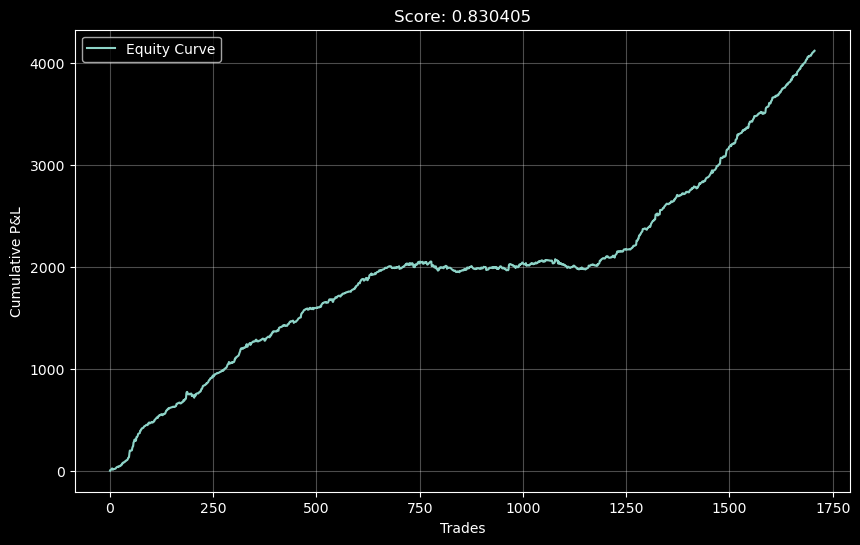

🔍 DEBUG: Tiempo de test in-sample: 0.13 segundos
🔍 DEBUG: Score in-sample: 0.8304048744151586
🔍 DEBUG: Modelos guardados en /tmp/tmp5mk3mg9v.onnx y /tmp/tmpmy_ca2vc.onnx
🔍   Nuevo mejor cluster 10: score = 0.8304048744151586
🔍   Evaluando cluster 2: 4217 filas main, 29498 filas meta
🔍 DEBUG fit_final_models - Parámetros CatBoost:
🔍   cat_main_*: {'cat_main_iterations': 400, 'cat_main_depth': 8, 'cat_main_learning_rate': 0.04730843286329205, 'cat_main_l2_leaf_reg': 1.2299000710368257, 'cat_main_early_stopping': 200}
🔍   cat_meta_*: {'cat_meta_iterations': 250, 'cat_meta_depth': 6, 'cat_meta_learning_rate': 0.023540704114146837, 'cat_meta_l2_leaf_reg': 8.849386007414783, 'cat_meta_early_stopping': 200}
🔍 DEBUG: Main model data shape: (4217, 37)
🔍 DEBUG: Main feature columns: ['5_maxdd_main_feature', '5_fisher_main_feature', '5_var_main_feature', '5_cv_main_feature', '6_maxdd_main_feature', '6_fisher_main_feature', '6_var_main_feature', '6_cv_main_feature', '10_maxdd_main_feature', '10_fi

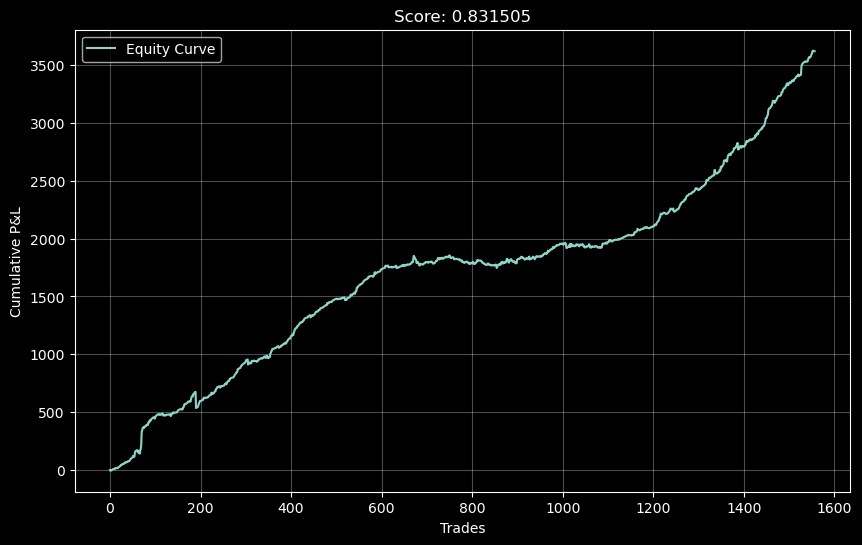

🔍 DEBUG: Tiempo de test in-sample: 0.19 segundos
🔍 DEBUG: Score in-sample: 0.8315046296627673
🔍 DEBUG: Modelos guardados en /tmp/tmp5ibh6o3c.onnx y /tmp/tmp52t6pvjz.onnx
🔍   Nuevo mejor cluster 2: score = 0.8315046296627673
🔍   Evaluando cluster 9: 4173 filas main, 29498 filas meta
🔍 DEBUG fit_final_models - Parámetros CatBoost:
🔍   cat_main_*: {'cat_main_iterations': 400, 'cat_main_depth': 8, 'cat_main_learning_rate': 0.04730843286329205, 'cat_main_l2_leaf_reg': 1.2299000710368257, 'cat_main_early_stopping': 200}
🔍   cat_meta_*: {'cat_meta_iterations': 250, 'cat_meta_depth': 6, 'cat_meta_learning_rate': 0.023540704114146837, 'cat_meta_l2_leaf_reg': 8.849386007414783, 'cat_meta_early_stopping': 200}
🔍 DEBUG: Main model data shape: (4173, 37)
🔍 DEBUG: Main feature columns: ['5_maxdd_main_feature', '5_fisher_main_feature', '5_var_main_feature', '5_cv_main_feature', '6_maxdd_main_feature', '6_fisher_main_feature', '6_var_main_feature', '6_cv_main_feature', '10_maxdd_main_feature', '10_fis

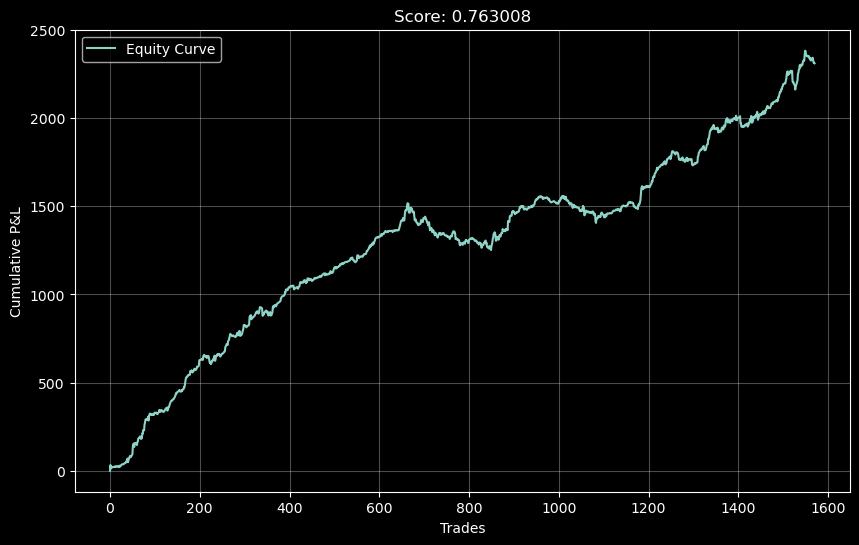

🔍 DEBUG: Tiempo de test in-sample: 0.12 segundos
🔍 DEBUG: Score in-sample: 0.7630082575837307
🔍 DEBUG: Modelos guardados en /tmp/tmpvikp5cvu.onnx y /tmp/tmpqs1l9033.onnx
🔍   Evaluando cluster 1: 3737 filas main, 29498 filas meta
🔍 DEBUG fit_final_models - Parámetros CatBoost:
🔍   cat_main_*: {'cat_main_iterations': 400, 'cat_main_depth': 8, 'cat_main_learning_rate': 0.04730843286329205, 'cat_main_l2_leaf_reg': 1.2299000710368257, 'cat_main_early_stopping': 200}
🔍   cat_meta_*: {'cat_meta_iterations': 250, 'cat_meta_depth': 6, 'cat_meta_learning_rate': 0.023540704114146837, 'cat_meta_l2_leaf_reg': 8.849386007414783, 'cat_meta_early_stopping': 200}
🔍 DEBUG: Main model data shape: (3737, 37)
🔍 DEBUG: Main feature columns: ['5_maxdd_main_feature', '5_fisher_main_feature', '5_var_main_feature', '5_cv_main_feature', '6_maxdd_main_feature', '6_fisher_main_feature', '6_var_main_feature', '6_cv_main_feature', '10_maxdd_main_feature', '10_fisher_main_feature', '10_var_main_feature', '10_cv_main_

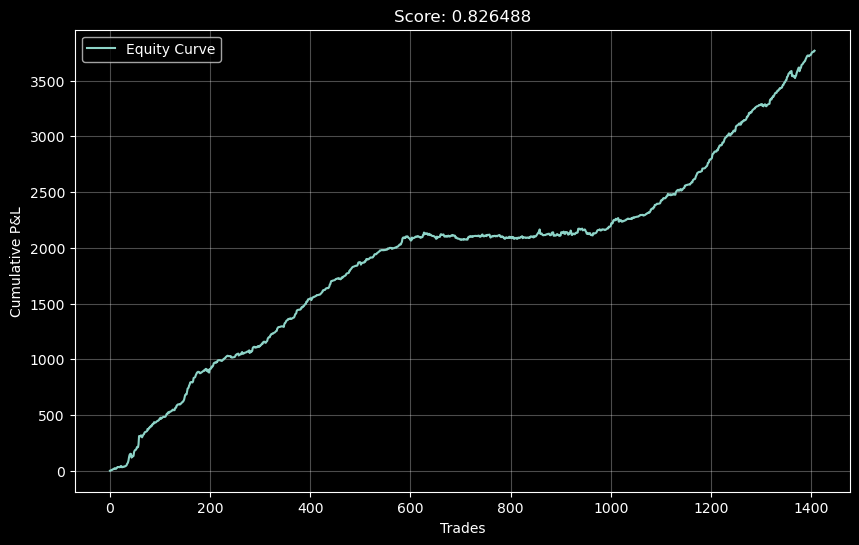

🔍 DEBUG: Tiempo de test in-sample: 0.14 segundos
🔍 DEBUG: Score in-sample: 0.8264876066382381
🔍 DEBUG: Modelos guardados en /tmp/tmpr37e5dke.onnx y /tmp/tmp65kbqsuq.onnx
🔍   Evaluando cluster 7: 3176 filas main, 29498 filas meta
🔍 DEBUG fit_final_models - Parámetros CatBoost:
🔍   cat_main_*: {'cat_main_iterations': 400, 'cat_main_depth': 8, 'cat_main_learning_rate': 0.04730843286329205, 'cat_main_l2_leaf_reg': 1.2299000710368257, 'cat_main_early_stopping': 200}
🔍   cat_meta_*: {'cat_meta_iterations': 250, 'cat_meta_depth': 6, 'cat_meta_learning_rate': 0.023540704114146837, 'cat_meta_l2_leaf_reg': 8.849386007414783, 'cat_meta_early_stopping': 200}
🔍 DEBUG: Main model data shape: (3176, 37)
🔍 DEBUG: Main feature columns: ['5_maxdd_main_feature', '5_fisher_main_feature', '5_var_main_feature', '5_cv_main_feature', '6_maxdd_main_feature', '6_fisher_main_feature', '6_var_main_feature', '6_cv_main_feature', '10_maxdd_main_feature', '10_fisher_main_feature', '10_var_main_feature', '10_cv_main_

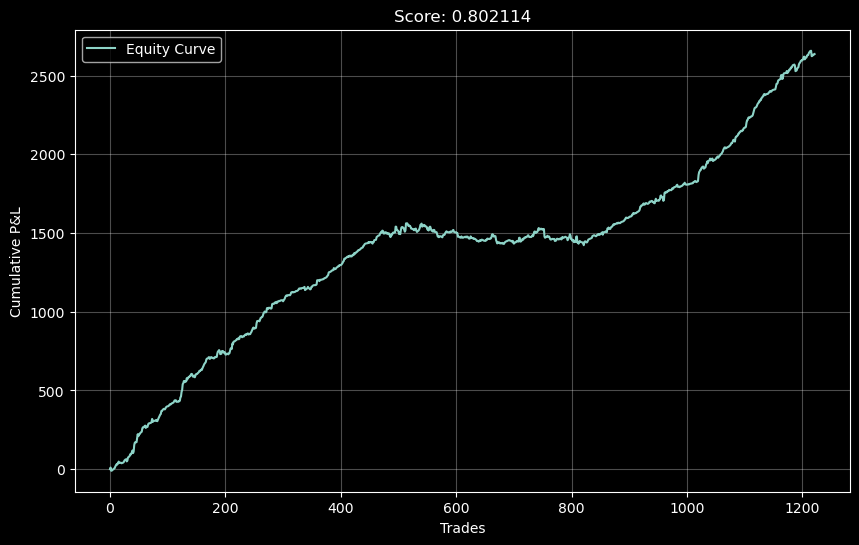

🔍 DEBUG: Tiempo de test in-sample: 0.19 segundos
🔍 DEBUG: Score in-sample: 0.8021139554213819
🔍 DEBUG: Modelos guardados en /tmp/tmpsc2_rgki.onnx y /tmp/tmp2efkrg_x.onnx
🔍   Evaluando cluster 4: 2651 filas main, 29498 filas meta
🔍 DEBUG fit_final_models - Parámetros CatBoost:
🔍   cat_main_*: {'cat_main_iterations': 400, 'cat_main_depth': 8, 'cat_main_learning_rate': 0.04730843286329205, 'cat_main_l2_leaf_reg': 1.2299000710368257, 'cat_main_early_stopping': 200}
🔍   cat_meta_*: {'cat_meta_iterations': 250, 'cat_meta_depth': 6, 'cat_meta_learning_rate': 0.023540704114146837, 'cat_meta_l2_leaf_reg': 8.849386007414783, 'cat_meta_early_stopping': 200}
🔍 DEBUG: Main model data shape: (2651, 37)
🔍 DEBUG: Main feature columns: ['5_maxdd_main_feature', '5_fisher_main_feature', '5_var_main_feature', '5_cv_main_feature', '6_maxdd_main_feature', '6_fisher_main_feature', '6_var_main_feature', '6_cv_main_feature', '10_maxdd_main_feature', '10_fisher_main_feature', '10_var_main_feature', '10_cv_main_

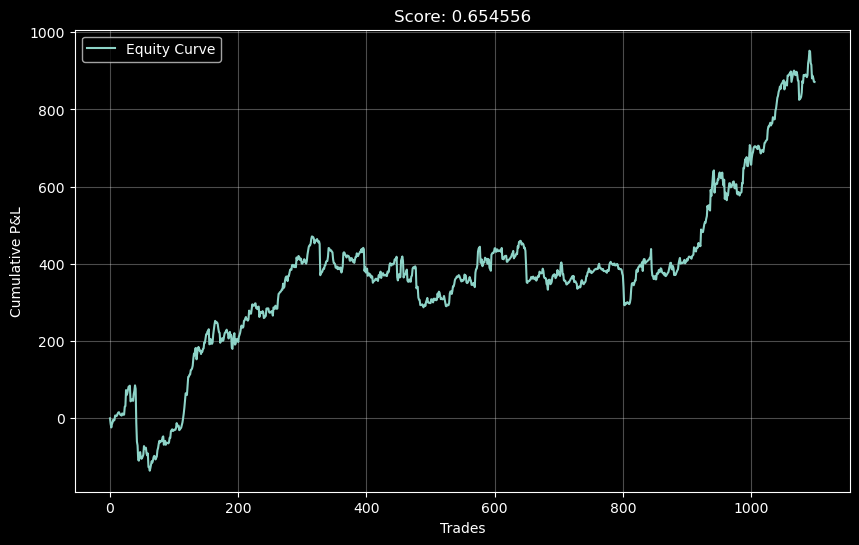

🔍 DEBUG: Tiempo de test in-sample: 0.10 segundos
🔍 DEBUG: Score in-sample: 0.6545558827170124
🔍 DEBUG: Modelos guardados en /tmp/tmpwj0pi9q5.onnx y /tmp/tmpkdeagbh6.onnx
🔍   Evaluando cluster 6: 2186 filas main, 29498 filas meta
🔍 DEBUG fit_final_models - Parámetros CatBoost:
🔍   cat_main_*: {'cat_main_iterations': 400, 'cat_main_depth': 8, 'cat_main_learning_rate': 0.04730843286329205, 'cat_main_l2_leaf_reg': 1.2299000710368257, 'cat_main_early_stopping': 200}
🔍   cat_meta_*: {'cat_meta_iterations': 250, 'cat_meta_depth': 6, 'cat_meta_learning_rate': 0.023540704114146837, 'cat_meta_l2_leaf_reg': 8.849386007414783, 'cat_meta_early_stopping': 200}
🔍 DEBUG: Main model data shape: (2186, 37)
🔍 DEBUG: Main feature columns: ['5_maxdd_main_feature', '5_fisher_main_feature', '5_var_main_feature', '5_cv_main_feature', '6_maxdd_main_feature', '6_fisher_main_feature', '6_var_main_feature', '6_cv_main_feature', '10_maxdd_main_feature', '10_fisher_main_feature', '10_var_main_feature', '10_cv_main_

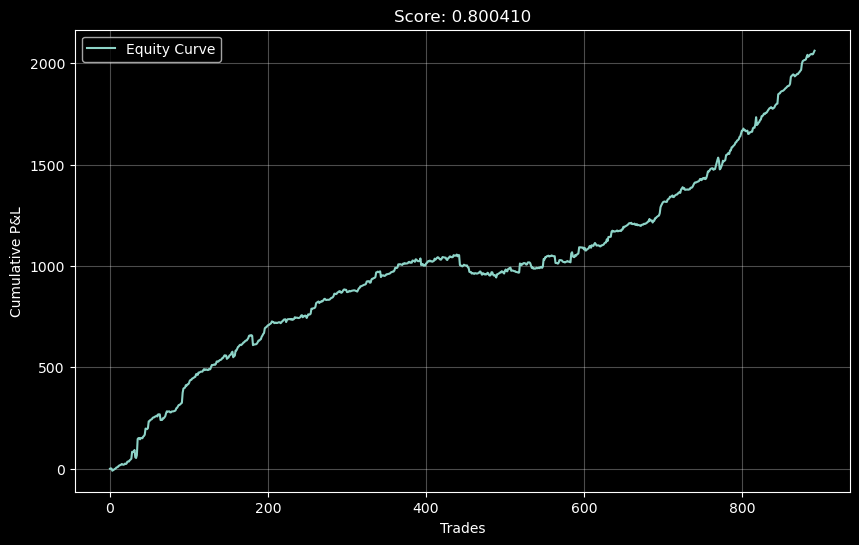

🔍 DEBUG: Tiempo de test in-sample: 0.17 segundos
🔍 DEBUG: Score in-sample: 0.8004098256337765
🔍 DEBUG: Modelos guardados en /tmp/tmpo5lrmc77.onnx y /tmp/tmpirbf109g.onnx
🔍   Evaluando cluster 5: 1807 filas main, 29498 filas meta
🔍 DEBUG fit_final_models - Parámetros CatBoost:
🔍   cat_main_*: {'cat_main_iterations': 400, 'cat_main_depth': 8, 'cat_main_learning_rate': 0.04730843286329205, 'cat_main_l2_leaf_reg': 1.2299000710368257, 'cat_main_early_stopping': 200}
🔍   cat_meta_*: {'cat_meta_iterations': 250, 'cat_meta_depth': 6, 'cat_meta_learning_rate': 0.023540704114146837, 'cat_meta_l2_leaf_reg': 8.849386007414783, 'cat_meta_early_stopping': 200}
🔍 DEBUG: Main model data shape: (1807, 37)
🔍 DEBUG: Main feature columns: ['5_maxdd_main_feature', '5_fisher_main_feature', '5_var_main_feature', '5_cv_main_feature', '6_maxdd_main_feature', '6_fisher_main_feature', '6_var_main_feature', '6_cv_main_feature', '10_maxdd_main_feature', '10_fisher_main_feature', '10_var_main_feature', '10_cv_main_

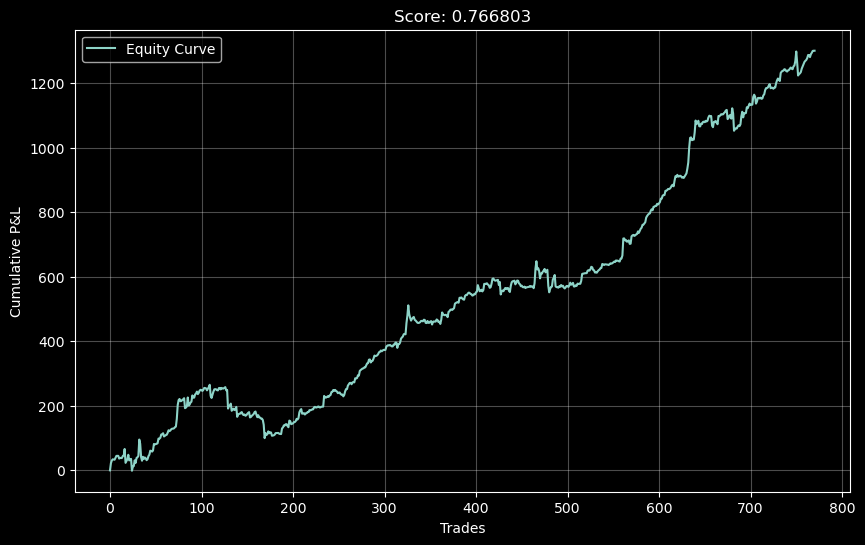

🔍 DEBUG: Tiempo de test in-sample: 0.12 segundos
🔍 DEBUG: Score in-sample: 0.7668034014278639
🔍 DEBUG: Modelos guardados en /tmp/tmpmbi_xfqf.onnx y /tmp/tmp4g9ou9gk.onnx
🔍   Evaluando cluster 8: 1136 filas main, 29498 filas meta
🔍 DEBUG fit_final_models - Parámetros CatBoost:
🔍   cat_main_*: {'cat_main_iterations': 400, 'cat_main_depth': 8, 'cat_main_learning_rate': 0.04730843286329205, 'cat_main_l2_leaf_reg': 1.2299000710368257, 'cat_main_early_stopping': 200}
🔍   cat_meta_*: {'cat_meta_iterations': 250, 'cat_meta_depth': 6, 'cat_meta_learning_rate': 0.023540704114146837, 'cat_meta_l2_leaf_reg': 8.849386007414783, 'cat_meta_early_stopping': 200}
🔍 DEBUG: Main model data shape: (1136, 37)
🔍 DEBUG: Main feature columns: ['5_maxdd_main_feature', '5_fisher_main_feature', '5_var_main_feature', '5_cv_main_feature', '6_maxdd_main_feature', '6_fisher_main_feature', '6_var_main_feature', '6_cv_main_feature', '10_maxdd_main_feature', '10_fisher_main_feature', '10_var_main_feature', '10_cv_main_

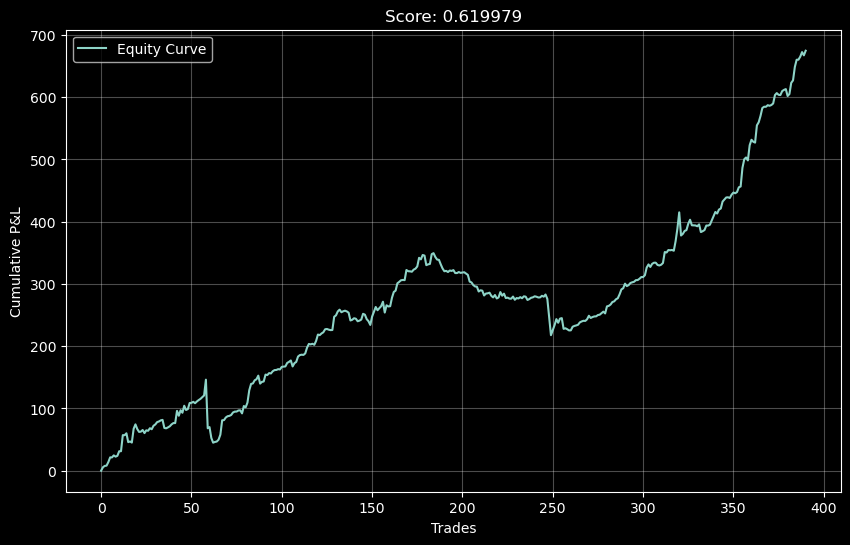

🔍 DEBUG: Tiempo de test in-sample: 0.11 segundos
🔍 DEBUG: Score in-sample: 0.6199785070665048
🔍 DEBUG: Modelos guardados en /tmp/tmpa2df5vi_.onnx y /tmp/tmpmn0ixoaz.onnx
🔍   Evaluando cluster 0: 1128 filas main, 29498 filas meta
🔍 DEBUG fit_final_models - Parámetros CatBoost:
🔍   cat_main_*: {'cat_main_iterations': 400, 'cat_main_depth': 8, 'cat_main_learning_rate': 0.04730843286329205, 'cat_main_l2_leaf_reg': 1.2299000710368257, 'cat_main_early_stopping': 200}
🔍   cat_meta_*: {'cat_meta_iterations': 250, 'cat_meta_depth': 6, 'cat_meta_learning_rate': 0.023540704114146837, 'cat_meta_l2_leaf_reg': 8.849386007414783, 'cat_meta_early_stopping': 200}
🔍 DEBUG: Main model data shape: (1128, 37)
🔍 DEBUG: Main feature columns: ['5_maxdd_main_feature', '5_fisher_main_feature', '5_var_main_feature', '5_cv_main_feature', '6_maxdd_main_feature', '6_fisher_main_feature', '6_var_main_feature', '6_cv_main_feature', '10_maxdd_main_feature', '10_fisher_main_feature', '10_var_main_feature', '10_cv_main_

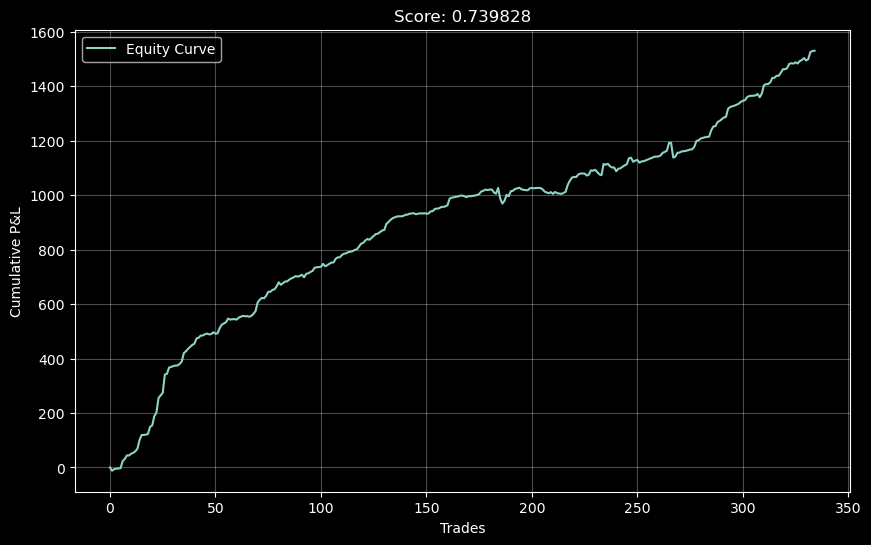

🔍 DEBUG: Tiempo de test in-sample: 0.12 segundos
🔍 DEBUG: Score in-sample: 0.7398279932486348
🔍 DEBUG: Modelos guardados en /tmp/tmpmvv9359j.onnx y /tmp/tmppp4ruc6u.onnx
🔍   Evaluando cluster 3: 414 filas main, 29498 filas meta
🔍 DEBUG fit_final_models - Parámetros CatBoost:
🔍   cat_main_*: {'cat_main_iterations': 400, 'cat_main_depth': 8, 'cat_main_learning_rate': 0.04730843286329205, 'cat_main_l2_leaf_reg': 1.2299000710368257, 'cat_main_early_stopping': 200}
🔍   cat_meta_*: {'cat_meta_iterations': 250, 'cat_meta_depth': 6, 'cat_meta_learning_rate': 0.023540704114146837, 'cat_meta_l2_leaf_reg': 8.849386007414783, 'cat_meta_early_stopping': 200}
🔍 DEBUG: Main model data shape: (414, 37)
🔍 DEBUG: Main feature columns: ['5_maxdd_main_feature', '5_fisher_main_feature', '5_var_main_feature', '5_cv_main_feature', '6_maxdd_main_feature', '6_fisher_main_feature', '6_var_main_feature', '6_cv_main_feature', '10_maxdd_main_feature', '10_fisher_main_feature', '10_var_main_feature', '10_cv_main_fe

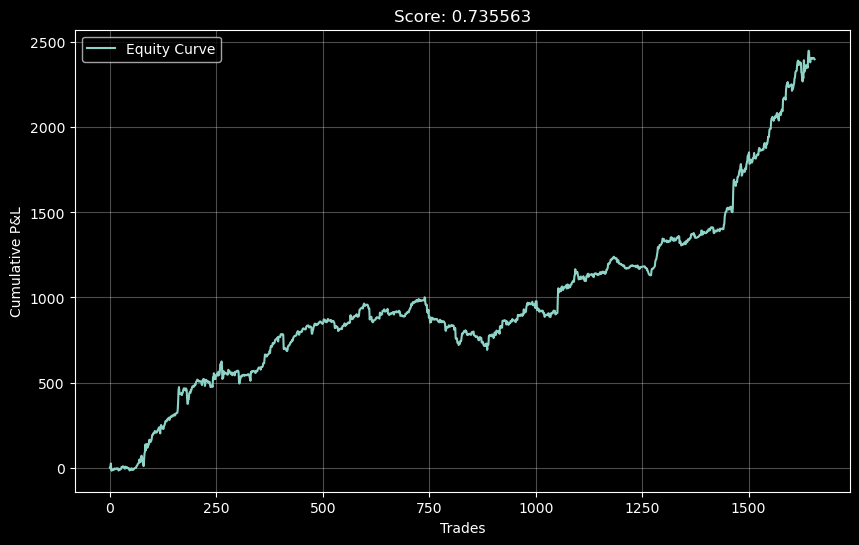

🔍 DEBUG: Tiempo de test in-sample: 0.07 segundos
🔍 DEBUG: Score in-sample: 0.7355631392592198
🔍 DEBUG: Modelos guardados en /tmp/tmp376pvsr0.onnx y /tmp/tmppyyf7kbk.onnx
🔍   Nuevo mejor cluster 0: score = 0.7355631392592198
🔍   Evaluando cluster 1: 1707 filas main, 29521 filas meta
🔍 DEBUG fit_final_models - Parámetros CatBoost:
🔍   cat_main_*: {'cat_main_iterations': 550, 'cat_main_depth': 8, 'cat_main_learning_rate': 0.008592475795119148, 'cat_main_l2_leaf_reg': 4.390872993080936, 'cat_main_early_stopping': 20}
🔍   cat_meta_*: {'cat_meta_iterations': 800, 'cat_meta_depth': 4, 'cat_meta_learning_rate': 0.0069462413445281635, 'cat_meta_l2_leaf_reg': 12.992412497965878, 'cat_meta_early_stopping': 20}
🔍 DEBUG: Main model data shape: (1707, 19)
🔍 DEBUG: Main feature columns: ['28_range_main_feature', '28_kurt_main_feature', '28_mad_main_feature', '30_range_main_feature', '30_kurt_main_feature', '30_mad_main_feature', '32_range_main_feature', '32_kurt_main_feature', '32_mad_main_feature', 

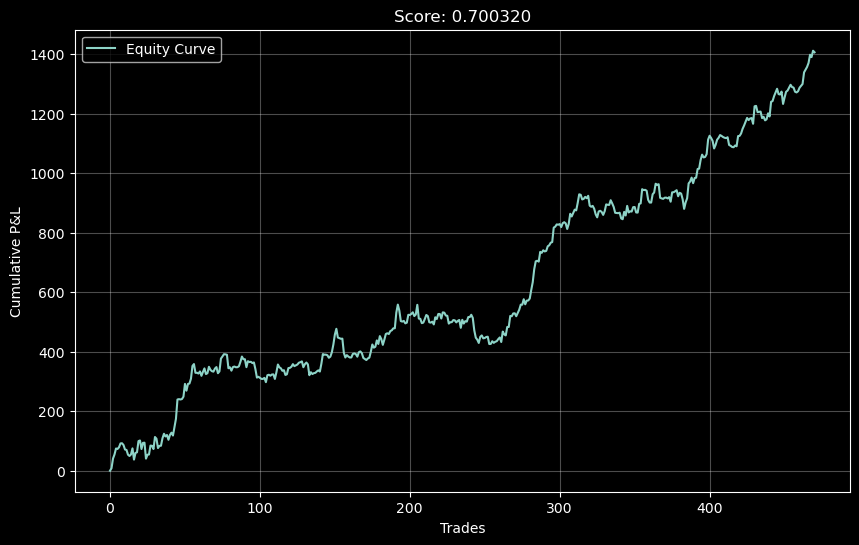

🔍 DEBUG: Tiempo de test in-sample: 0.10 segundos
🔍 DEBUG: Score in-sample: 0.7003199274231606
🔍 DEBUG: Modelos guardados en /tmp/tmpquxqcvnc.onnx y /tmp/tmp0bi8lwhr.onnx
🔍   Evaluando cluster 2: 54 filas main, 29521 filas meta
🔍 DEBUG fit_final_models - Parámetros CatBoost:
🔍   cat_main_*: {'cat_main_iterations': 550, 'cat_main_depth': 8, 'cat_main_learning_rate': 0.008592475795119148, 'cat_main_l2_leaf_reg': 4.390872993080936, 'cat_main_early_stopping': 20}
🔍   cat_meta_*: {'cat_meta_iterations': 800, 'cat_meta_depth': 4, 'cat_meta_learning_rate': 0.0069462413445281635, 'cat_meta_l2_leaf_reg': 12.992412497965878, 'cat_meta_early_stopping': 20}
🔍 DEBUG: Main model data shape: (54, 19)
🔍 DEBUG: Main feature columns: ['28_range_main_feature', '28_kurt_main_feature', '28_mad_main_feature', '30_range_main_feature', '30_kurt_main_feature', '30_mad_main_feature', '32_range_main_feature', '32_kurt_main_feature', '32_mad_main_feature', '59_range_main_feature', '59_kurt_main_feature', '59_mad_m

In [ ]:
import optuna
from datetime import datetime
from concurrent.futures import ProcessPoolExecutor, as_completed
from modules.StrategySearcher import StrategySearcher
import warnings
import os
warnings.filterwarnings("ignore")

label_methods = [
    "random",
    "trend",
    "trend_profit",
    "trend_multi",
    "clusters",
    "multi_window",
    "validated_levels",
    "zigzag",
    "mean_rev",
    "mean_rev_multi",
    "mean_rev_vol",
    "filter",
    "multi_filter",
    "filter_bidirectional",
    "filter_one",
    "trend_one",
    "filter_flat",
]
search_methods = [
    'clusters',
    'markov',
    'lgmm',
    'wkmeans',
    'mapie',
    'causal',
]

configs = [
    dict(
        symbol='XAUUSD', timeframe='H1', direction='buy', pruner_type='sucessive',
        train_start=datetime(2020,1,1), train_end=datetime(2025,1,1),
        test_start=datetime(2022,1,1),  test_end=datetime(2023,6,1),
        label_method='random', search_type='lgmm', search_subtype='',
        n_models=1, debug=True,
    ),
]

# Actualizar n_jobs en cada configuración
for cfg in configs:
    cfg["tag"] = f"{cfg['symbol']}_{cfg['timeframe']}_{cfg['direction']}_{cfg['label_method']}_{cfg['search_type']}_{cfg.get('search_subtype', '')}".strip("_")

DB_FILE = f"optuna_dbs/{cfg['tag']}.db"
DB_PATH = f"sqlite:///{DB_FILE}"
STUDY_NAME = f"{cfg['tag']}"

study = None
if not os.path.exists(DB_FILE):
    study = None
else:
    try:
        study = optuna.load_study(study_name=STUDY_NAME, storage=DB_PATH)
    except Exception:
        study = None
if not study:
    n_trials = 5000
else:
    n_trials = len(study.trials) + 5000

for cfg in configs:
    cfg['n_trials'] = n_trials

def launch(cfg):
    s = StrategySearcher(**cfg)
    s.run_search()

with ProcessPoolExecutor(max_workers=len(configs)) as pool:
    futures = {pool.submit(launch, c): c["tag"] for c in configs}
    for f in as_completed(futures):
        tag = futures[f]
        try:
            print(f"[{tag}] terminado")
        except Exception as e:
            print(f"[{tag}] falló: {e}")